In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

def plot(x, y):
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, edgecolors='black', linewidths=1.0)

label = 'SalePrice'
living_area = 'GrLivArea'
data = pd.read_csv('house_price.csv')
data = pd.get_dummies(data).dropna(axis=1)

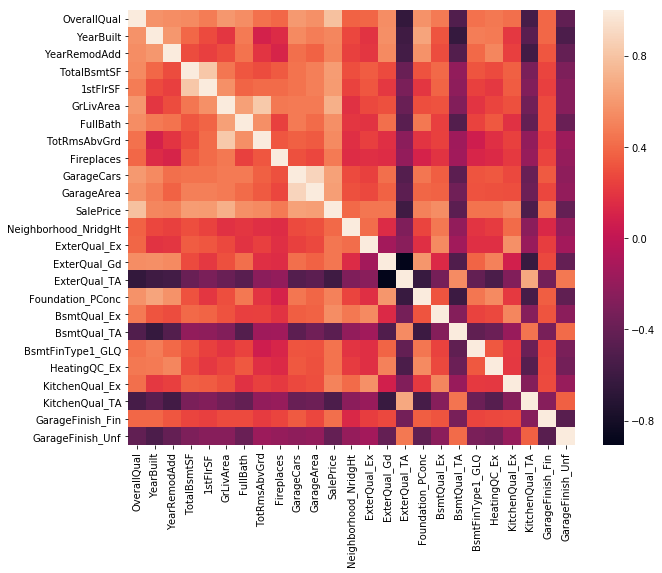

In [136]:
corr = data.corr()
most_corr_features = corr.index[abs(corr[label])>0.4]
most_corr = data[most_corr_features].corr()

f = plt.figure(figsize=(10, 8))
sns.heatmap(most_corr, annot=False)

In [137]:
features = most_corr_features.drop(label)
features = list(filter(lambda f: not re.search("[& ]", f), features))

x = data[features]
y = pd.Series(data[label])

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
x = pd.DataFrame(x, columns=features)


/Users/sroik/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [138]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 24)
(292, 24)
(1168,)
(292,)


# Tensorflow

In [139]:
import tensorflow as tf

def build_input_fn(x, y, shuffle=False, epochs=None):
    return tf.estimator.inputs.pandas_input_fn(
        x=x,
        y=y, 
        batch_size=128, 
        shuffle=shuffle,
        num_epochs=epochs)
    
train_input_fn = build_input_fn(x=x_train, y=y_train, shuffle=True)
test_input_fn = build_input_fn(x=x_test, y=y_test, epochs=1)

In [140]:
numeric_columns = [tf.feature_column.numeric_column(key=c) for c in features]
regressor = tf.estimator.DNNRegressor(hidden_units=[20,20,20], feature_columns=numeric_columns)
regressor.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/ry/lvr5m8cd5r94mt6hxn3lbc_40000gn/T/tmpnpor0303', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x142fcde48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Chec

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ry/lvr5m8cd5r94mt6hxn3lbc_40000gn/T/tmpnpor0303/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Score:  0.6597438122046975
MAE:  30631.83360980308


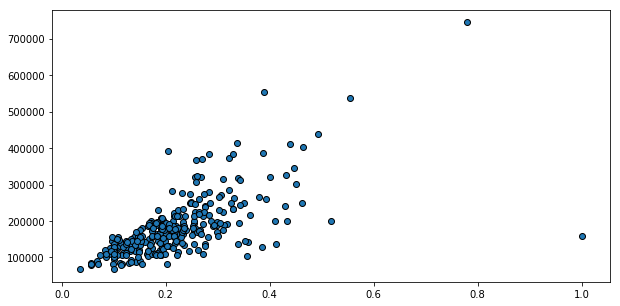

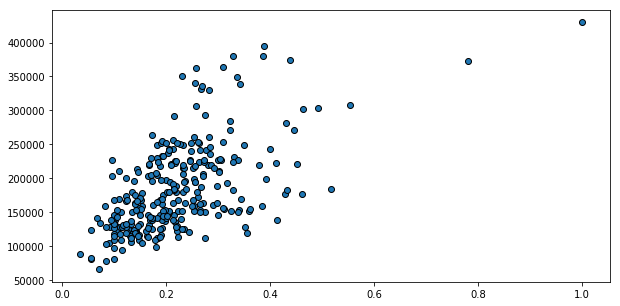

In [141]:
result = regressor.predict(input_fn=test_input_fn)
pred = [r["predictions"][0] for r in result]

plot(x_test[living_area], y_test)
plot(x_test[living_area], pred)

score = explained_variance_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
print("Score: ", score)
print("MAE: ", mae)

# Sklearn

In [142]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model score:  0.859884699509349
Score:  0.859895745234898
MAE:  18638.504316699284


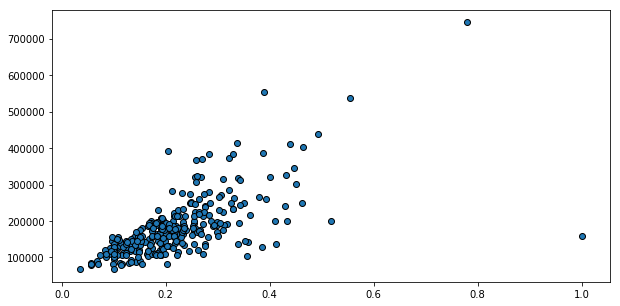

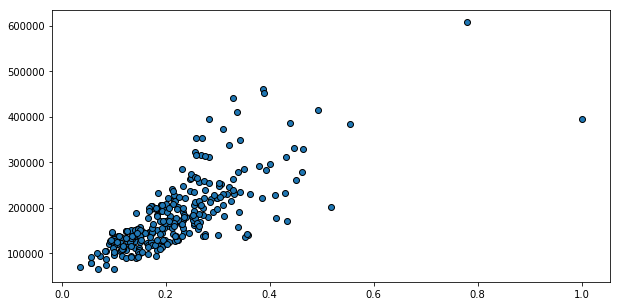

In [143]:
pred = regressor.predict(x_test)

plot(x_test[living_area], y_test)
plot(x_test[living_area], pred)

model_score = regressor.score(x_test, y_test)
score = explained_variance_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
print("Model score: ", model_score)
print("Score: ", score)
print("MAE: ", mae)

# Keras

In [144]:
from keras.models import Sequential
from keras.layers import Dense

def keras_model():
    model = Sequential()
    model.add(Dense(20, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

In [148]:
model = keras_model()
print(model.summary)
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x143ab27f0>>
Train on 934 samples, validate on 234 samples
Epoch 1/200
934/934 [==============================] - 1s 837us/step - loss: 40163747721.5932 - mean_squared_error: 40163747721.5932 - mean_absolute_error: 183249.3364 - val_loss: 33599111097.9829 - val_mean_squared_error: 33599111097.9829 - val_mean_absolute_error: 171064.9157
Epoch 2/200
934/934 [==============================] - 0s 52us/step - loss: 40163127274.0728 - mean_squared_error: 40163127274.0728 - mean_absolute_error: 183247.7617 - val_loss: 33598327606.7009 - val_mean_squared_error: 33598327606.7009 - val_mean_absolute_error: 171062.7540
Epoch 3/200
934/934 [==============================] - 0s 56us/step - loss: 40161965216.0685 - mean_squared_error: 40161965216.0685 - mean_absolute_error: 183244.8047 - val_loss: 33596922013.5385 - val_mean_squared_error: 33596922013.5385 - val_mean_absolute_error: 171058.8715
Epoch 4/200
934/934 [=====

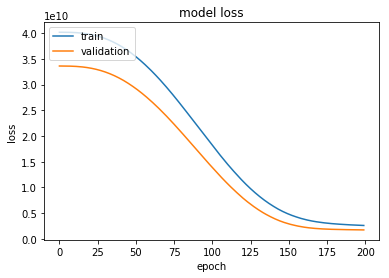

In [149]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Score:  0.5618759611348642
MAE:  35925.086445847606


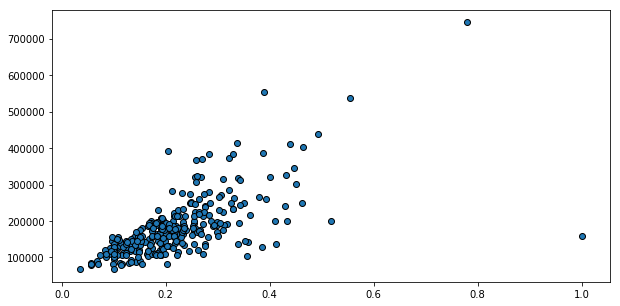

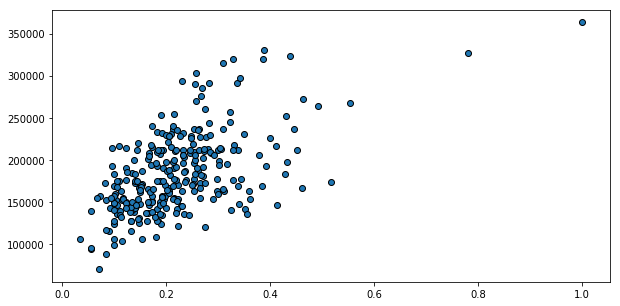

In [150]:
pred = model.predict(x_test)

plot(x_test[living_area], y_test)
plot(x_test[living_area], pred)

score = explained_variance_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
print("Score: ", score)
print("MAE: ", mae)